# Machine learning avec les modules Python tensorflow2/keras :

# Entraînement / exploitation d'un réseau de neurones convolutif pour la reconnaissance de micrographies matérieux

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    Il est fondamental d'utiliser un <span style="font-weight:bold;">Environnement Virtuel Python</span> (EVP) pour chaque projet Python important : l'EVP permet de maîtriser pour chaque projet les versions de l'interpréteur Python et des modules "sensibles" (comme tensorflow par exemple).

## Import des modules Python

In [1]:
# supprimer l'affichage des warnings tensorflow:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import sys, random, cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.8.16
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.24.3
OpenCV    : 4.5.1


In [3]:
#permet de visualiser les graphiques directement dans la cellule du N.B.
%matplotlib inline

# On donne des poids aléatoires au réseau de neurones
# SEED sert à obtenir des suites de nombres aléatoires reproductibles
SEED = 43
np.random.seed(SEED)
random.seed(SEED)

## Read images from the directory ../Data

In [4]:
import os
os.getcwd()

'/home/jlc/work/IA-MachineLearning/11-ClassificationMatériaux/Notebooks'

In [5]:
os.listdir('..')

['Data', 'base de donées RESA.zip', 'Notebooks']

### Resizing images

We assume here that `img` is a *ndarray* containing an image of dimensions $(W, H, C)$: for example (100, 200, 3) for a RGB color image of 100 pixels width $\times$ 200 pixels height, or (100, 200, 1) for the same *grayscale* image. <br>
Remember that the shape of the `img` ndarray is the tuple `(H,W,C)` $\leadsto$ `H` and `W` are swapped in the ndarray associated to the image.<br>
We want to *resize* the image in $w \times h$ pixels:.

In [5]:
images, labels = [], []
new_size = (600, 400)

image_dir = "../Data"
list_dir = os.listdir(image_dir)
list_dir.sort()
list_label = range(len(list_dir))
for d, lab  in zip(list_dir, list_label):
    print(f'\nLabel: {lab} - texte: {d} :')
    
    files = os.listdir(os.path.join('../Data', d))
    for f in files:
        image_path = os.path.join('../Data', d, f)
        print(f'\rreading file {image_path}', end='')
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # conversion en tons de gris
        img = cv2.resize(img, dsize=new_size)
        images.append(img)
        labels.append(lab)
    
images = np.array(images)
labels = np.array(labels)
label_text = list_dir


Label: 0 - texte: 1 :
reading file ../Data/1/X24-000042.jpg
Label: 1 - texte: 2 :
reading file ../Data/2/M7_000075.jpg
Label: 2 - texte: 3 :
reading file ../Data/3/X20_000088.jpg

In [6]:
label_text

['1', '2', '3']

In [7]:
len(images)

320

In [8]:
images[0].shape

(400, 600)

In [9]:
print(f"images -> shape: {images.shape}, dtype: {images.dtype}")
print(f"labels -> shape: {labels.shape}, dtype: {labels.dtype}")

images -> shape: (320, 400, 600), dtype: uint8
labels -> shape: (320,), dtype: int64


Split the arrays `images` and `labels` into a `train` dataset (for the training) and a `test` dataset.<br>
Images and labels are randomly selected but respecting the proportion of each of the classes in the two original datasets (this is the interest of the `stratify` argument passed to the 'train_test_split' conction):

In [10]:
from sklearn.model_selection import train_test_split

im_train, im_test, lab_train, lab_test = train_test_split(images, labels,
                                                          stratify=labels,  # use labels to evenly distribute all 
                                                                            # classes in the train and test dadasets
                                                        test_size=0.15,     # 15 % test, 85% train 
                                                        random_state=SEED, 
                                                        shuffle=True)       # shuffe randomly the data

Check: display a train image randomy selected:

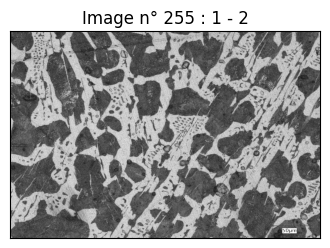

In [11]:
n_image = np.random.randint(0,len(im_train))

plt.figure(figsize=(4,4))
plt.imshow(im_train[n_image], cmap='gray')
plt.title(f'Image n° {n_image} : {lab_train[n_image]} - {label_text[lab_train[n_image]]}')
plt.xticks([]); plt.yticks([]);

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered:
- with the shape attribute of the `im_train` and `im_test` arrays
- with the size attribute of the first training image for example


In [12]:
# number of training images:
nb_im_train = im_train.shape[0]

# number of test images:
nb_im_test  = im_test.shape[0]     

# number of elements (pixels) of the firts training image: 
nb_pixel    = im_train[0].size   

# Visual checking:
print(f"{nb_im_train} training images and {nb_im_test} test images")
print(f"{im_train.shape[1]}x{im_train.shape[2]}={nb_pixel} pixels in each image")

# number of classes:
nb_classe = len(set(labels))
print(f"{nb_classe} different classes found in the `labels` array")

272 training images and 48 test images
400x600=240000 pixels in each image
3 different classes found in the `labels` array


### Formatting input data

The convolutional layers of the *kera*s module expect 4-dimensional arrays `(batch_size, height, width, depth)` by default:
- `batch_size`: number of input images,
- `height` and `width`: height and width of images (in pixels),
- `depth`: depth of the arrays (`3` for an RGB image, `1` for a grayscale image).

The form of our images is:

In [13]:
im_train.shape, im_test.shape

((272, 400, 600), (48, 400, 600))

It is therefore necessary to add a dimension (equal to `1`) after the third dimension `800`, for example with the `reshape` method of the `ndarray` arrays of numpy, without forgetting to divide the arrays by 255 to __normalize__ them entries:

In [14]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

Check:

In [15]:
im_train.shape, x_train.shape, x_train.min(), x_train.max(),

((272, 400, 600), (272, 400, 600, 1), 0.0, 1.0)

In [16]:
im_test.shape, x_test.shape, x_test.min(), x_test.max()

((48, 400, 600), (48, 400, 600, 1), 0.0, 1.0)

### One-hot formatting of labels

In [17]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of the train and test labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Check: display the first 10 values of `lab_train` and `y_train` :

In [18]:
print(lab_train[:10])
print(y_train[:10])

[2 1 0 0 1 0 1 1 0 1]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


## Build the convolutional neural network

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D,  MaxPool2D, Flatten

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
tf.random.set_seed(SEED)

model = Sequential(name='LeNet5')
model.add(Input(shape=x_train[0].shape))
model.add(Conv2D(6, 5, padding='same', activation='relu', name='C1'))
model.add(MaxPool2D(pool_size=2, name='S2'))
model.add(Conv2D(16, 5, padding='valid', activation='relu', name='C3'))
model.add(MaxPool2D(pool_size=2, name='S4'))
model.add(Flatten())
model.add(Dense(200, activation='relu', name='C5'))
model.add(Dense(84, activation='relu', name='F6'))
model.add(Dense(nb_classe, activation='softmax', name='Output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 400, 600, 6)       156       
                                                                 
 S2 (MaxPooling2D)           (None, 200, 300, 6)       0         
                                                                 
 C3 (Conv2D)                 (None, 196, 296, 16)      2416      
                                                                 
 S4 (MaxPooling2D)           (None, 98, 148, 16)       0         
                                                                 
 flatten (Flatten)           (None, 232064)            0         
                                                                 
 C5 (Dense)                  (None, 200)               46413000  
                                                                 
 F6 (Dense)                  (None, 84)                16884

### Save the initial state of the network (structure & data)

You can save the the initial weights of the untrained network (random values) and its structure with the `Model.save` method. <br>
This will be useful later to recreate the network to its initial state before running other trainings again:

In [22]:
import os

# Check wether the 'model' exist and create it if not:
if not os.path.exists("models"): os.mkdir("models")

# save the structure and the initial waights of the network:
key = 'conv2_init'
model.save('models/'+key)

# display the files:
files=[os.path.join("models",f) for f in os.listdir("models")]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/conv2_init/assets
models/conv2_init
models/conv1_trained_bs-10_ep-15_es-acc-2
models/conv1_init


## Train the network with test every *epoch*

### Automatically stop training before over-fit
Keras offers tools to automatically stop learning by monitoring for example the growth of `val_accuracy` or the decrease of `val_loss` from one epoch to another (see the _EarlyStopping_ callback).

We can thus define a list of callback functions that we pass as an argument to the fit function with the agument named callbacks:

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=3,              # accepter que 'val_accuracy' diminue 
                  restore_best_weights=True,
                  verbose=1)
]

# reload the initial state of the network:
key = 'conv2_init'

# define the path used:
model_path = os.path.join('models', key)

# load the network structure and initial weights:
model = tf.keras.models.load_model(model_path)

# set the seed for the random generators:
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=25, 
                 batch_size=10, 
                 callbacks = callbacks_list)

Epoch 1/25
28/28 [==============================] - 18s 634ms/step - loss: 3.0875 - accuracy: 0.4485 - val_loss: 1.0940 - val_accuracy: 0.6667
Epoch 2/25
28/28 [==============================] - 17s 620ms/step - loss: 1.0717 - accuracy: 0.6176 - val_loss: 0.9587 - val_accuracy: 0.3542
Epoch 3/25
28/28 [==============================] - 18s 631ms/step - loss: 0.8532 - accuracy: 0.6544 - val_loss: 0.8290 - val_accuracy: 0.6458
Epoch 4/25
28/28 [==============================] - 17s 600ms/step - loss: 0.3680 - accuracy: 0.9522 - val_loss: 0.8513 - val_accuracy: 0.6875
Epoch 5/25
28/28 [==============================] - 17s 601ms/step - loss: 0.0990 - accuracy: 0.9963 - val_loss: 0.4113 - val_accuracy: 0.7917
Epoch 6/25
28/28 [==============================] - 17s 611ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2588 - val_accuracy: 0.8542
Epoch 7/25
28/28 [==============================] - 17s 609ms/step - loss: 3.0321e-04 - accuracy: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.

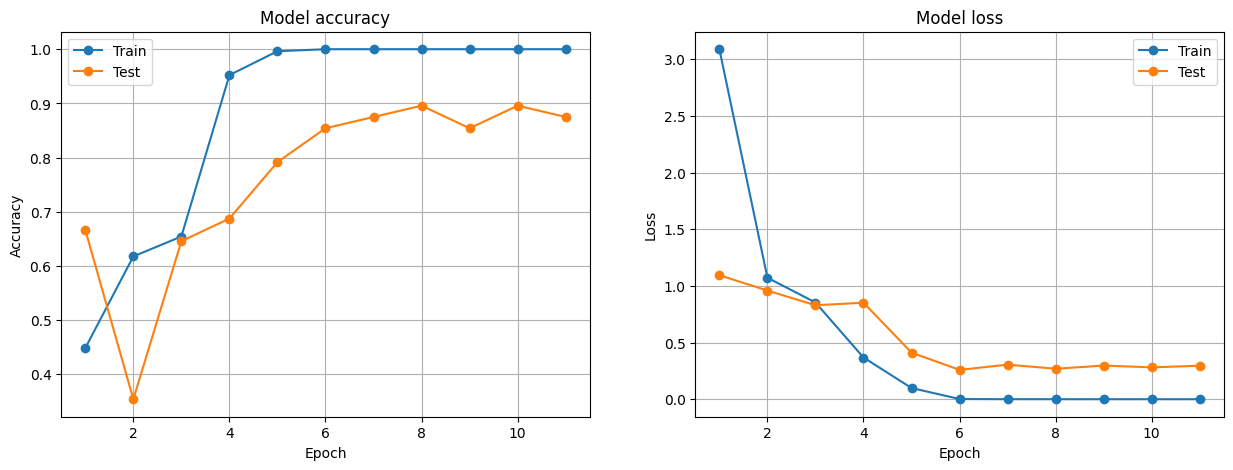

In [26]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Save the structure and the weights of the trained network

In [27]:
import os

# save the structure and the trained weights of the network:
key = 'conv2_trained_bs-10_ep-15_es-acc-3'
model.save('models/'+key) 

# display the files:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/conv2_trained_bs-10_ep-15_es-acc-3/assets
models/conv2_trained_bs-10_ep-15_es-acc-3


### Show confusion matrix

In [28]:
# recharger l'état initial du réseau:
key = 'conv2_trained_bs-10_ep-15_es-acc-3'
# définir le chemin d'accès du réseau entraîné dans le notebook précédent :
model_path = os.path.join('models', key)
# charger le réseau
model = tf.keras.models.load_model(model_path)

In [29]:
results = model.predict(x_test)          # restults is an array of probabilities vectors
inferences = results.argmax(axis=-1)     # extract the highest probablities

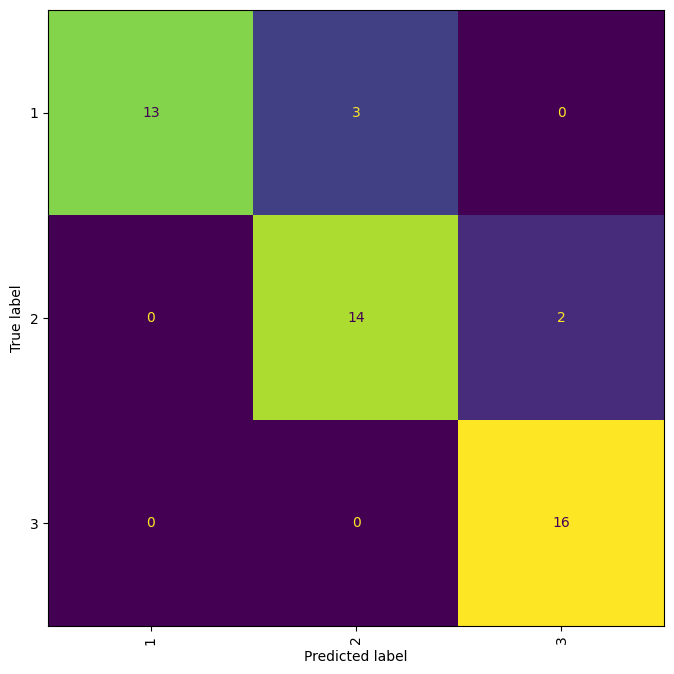

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(8,8))
axis = plt.axes()

ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=label_text, 
                                        xticks_rotation='vertical',
                                        colorbar=False);

### Tester des images spécifiques

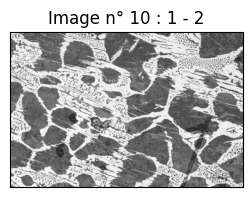

In [38]:
plt.figure(figsize=(3,3))
n = 10
plt.imshow(x_test[n], cmap='gray')
plt.title(f'Image n° {n} : {lab_test[n]} - {label_text[lab_test[n]]}')
plt.xticks([]); plt.yticks([]);

In [39]:
results = model.predict(x_test[n:n+1])
answer = results.argmax()
print(f"Network classification: {answer} with score {results[0, answer]*100:.1f}%")

Network classification: 1 with score 58.9%


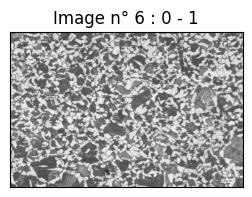

In [40]:
plt.figure(figsize=(3,3))
n = 6
plt.imshow(im_test[n], cmap='gray')
plt.title(f'Image n° {n} : {lab_test[n]} - {label_text[lab_test[n]]}')
plt.xticks([]); plt.yticks([]);

In [41]:
results = model.predict(x_test[n:n+1])
answer = results.argmax()
print(f"Network classification: {answer} with score {results[0, answer]*100:.1f}%")

Network classification: 0 with score 95.2%


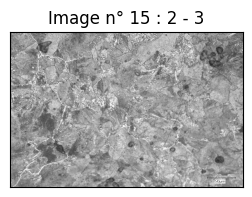

In [44]:
plt.figure(figsize=(3,3))
n = 15
plt.imshow(im_test[n], cmap='gray')
plt.title(f'Image n° {n} : {lab_test[n]} - {label_text[lab_test[n]]}')
plt.xticks([]); plt.yticks([]);

In [45]:
results = model.predict(x_test[n:n+1])
answer = results.argmax()
print(f"Network classification: {answer} with score {results[0, answer]*100:.1f}%")

Network classification: 2 with score 99.6%
